## Group project: implement a hand digit recognition classifier using CNN in Keras(TensorFlow Backend)

Due on Sunday,May 6th (11:59PM) 

### Group Members (UNI & Name):
yg2499, Yang GAO <br>
jc4884, Jiayi CUI <br>
qz2317, Qingyang ZHONG

### Requirement
* Try to understand the following link (https://www.tensorflow.org/tutorials/layers) and implement CNN classifier for MNIST data by adding extra layers or tuning the model.(Accuracy is not important, but implementation is must) <br>
* Download the dataset from following link (http://yann.lecun.com/exdb/mnist/). It has both training and test data. If it is computationally expensive, try to use 50% of the data to fit the model.<br>
* Implement the model in Python3.<br>
* Please cite, if you use any existing code or resources.
* Helpful Resources<br>
• http://cs231n.github.io/convolutional-networks/ <br>
• https://adeshpande3.github.io/A-Beginner%27sGuide-To-Understanding-Convolutional-NeuralNetworks/ <br>
• https://ujjwalkarn.me/2016/08/11/intuitiveexplanation-convnets/  <br>
• https://xrds.acm.org/blog/2016/06/convolutionalneural-networks-cnns-illustrated-explanation/ <br>
• https://cambridgespark.com/content/tutorials/convolutional-neural-networks-with-keras/index.html


## Extra Credit

1. Improve the model further (test accuracy >=99.5%) <br>
2. Fix the bug for the Keras MNIST sample code <br>
https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py

In [1]:
import numpy as np
import os
import gzip
import struct
import array
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import tensorflow as tf
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam
from sklearn.model_selection import ShuffleSplit
from keras.models import load_model
from sklearn.metrics import accuracy_score
%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#set seeds
np.random.seed(123)

### Data Loading

In [3]:
#relative PATH
path ='../data/'

In [14]:
# import self-defined functions
import sys 
sys.path.append('../lib/') 
from parse import parse_images
from parse import parse_labels
from one_hot_encode import one_hot_encode

In [8]:
#load gz files and encode dataset
X_train_0 = parse_images(path +'train-images-idx3-ubyte.gz')
y_train_0 = parse_labels(path +'train-labels-idx1-ubyte.gz')
X_test_0 = parse_images(path +'t10k-images-idx3-ubyte.gz')
y_test_0  = parse_labels(path +'t10k-labels-idx1-ubyte.gz')

In [9]:
y_train_0 =y_train_0.ravel()
y_test_0 =y_test_0.ravel()

In [10]:
#pick last 10000 rows in train data as valid data
train_data, valid_data = X_train_0[:-10000], X_train_0[-10000:]
train_labels, valid_labels = y_train_0[:-10000], y_train_0[-10000:]

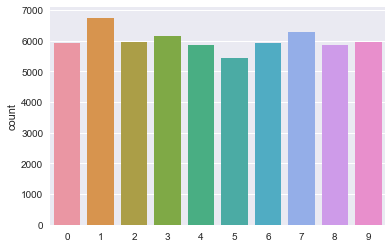

In [11]:
sns.set(style="darkgrid")
ax = sns.countplot(y_train_0)

### Data Pre-processing

In [15]:
#one-hot-encode for label
y_train =one_hot_encode(train_labels)
y_valid =one_hot_encode(valid_labels)
y_test =one_hot_encode(y_test_0)

In [16]:
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(50000, 10)
(10000, 10)
(10000, 10)


In [17]:
#normalization for X
#change [0:255] to [0:1]
def normalize(x):
    #image shape is (28,28)
    return  (x - np.min(x)) / (np.max(x) - np.min(x))

#X_train= np.multiply(X_train, 1.0 / 255.0)
#X_test= np.multiply(X_test, 1.0 / 255.0)
X_train_1 =normalize(train_data)
X_valid_1 =normalize(valid_data)
X_test_1 =normalize(X_test_0)

In [18]:
print(X_train_1.shape)
print(X_valid_1.shape)
print(X_test_1.shape)

(50000, 28, 28)
(10000, 28, 28)
(10000, 28, 28)


In [19]:
# reshape (60000,28,28) to (60000,28,28,1) shape 
X_train =X_train_1.reshape((-1, X_train_1.shape[1], X_train_1.shape[2], 1))
X_valid =X_valid_1.reshape((-1, X_valid_1.shape[1], X_valid_1.shape[2], 1))
X_test =X_test_1.reshape((-1, X_test_1.shape[1], X_test_1.shape[2], 1))

In [20]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(50000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)


### Data Visualization (Train & Test Data)

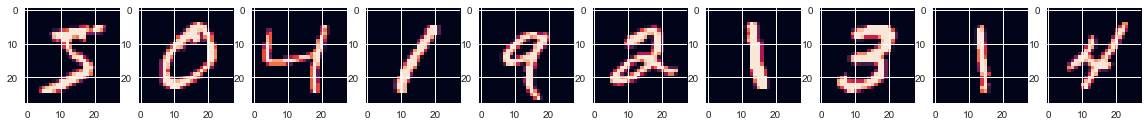

In [21]:
#show train dataset image
plt.figure(figsize=(20,10))
for i in range(10):
    plt.subplot(1,10,1+i)
    plt.imshow(train_data[i])

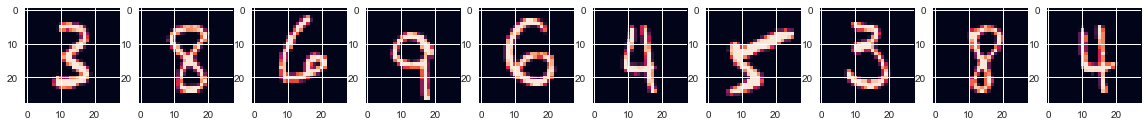

In [22]:
#show valid dataset image
plt.figure(figsize=(20,10))
for i in range(10):
    plt.subplot(1,10,1+i)
    plt.imshow(valid_data[i])

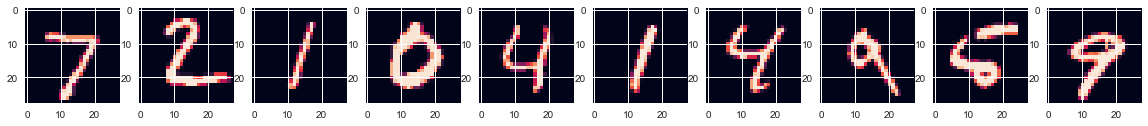

In [23]:
#show test dataset image
plt.figure(figsize=(20,10))
for i in range(10):
    plt.subplot(1,10,1+i)
    plt.imshow(X_test_0[i])

### Build CNN Model (Use Keras)

Follow the guide: <br>
[A Guide to TF Layers: Building a Convolutional Neural Network](https://www.tensorflow.org/tutorials/layers)<br>
https://blog.plon.io/tutorials/cifar-10-classification-using-keras-tutorial/

In [32]:
#set parameters
input_shape =(28,28,1) #shape =(height,weight,channel)
epochs = 40           #number of running
batch_size =256       #batch size of running

In [33]:
#build keras CNN model
model = Sequential()

#1st layer
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = input_shape))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#2nd layer
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

#flatten
model.add(Flatten())

#add dense
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.50))
model.add(Dense(10, activation = "softmax"))

#set up learning_rate 
model.compile(optimizer = RMSprop() , loss = "categorical_crossentropy", metrics=["accuracy"])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 64)          0         
__________

In [34]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)

In [ ]:
# Data augmentation

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

In [36]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_valid,y_valid),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction],)

Epoch 1/40
195/195 [==============================] - 10s - loss: 0.5378 - acc: 0.8279 - val_loss: 0.0806 - val_acc: 0.9740
Epoch 2/40
195/195 [==============================] - 10s - loss: 0.1610 - acc: 0.9516 - val_loss: 0.0370 - val_acc: 0.9878
Epoch 3/40
195/195 [==============================] - 10s - loss: 0.1095 - acc: 0.9666 - val_loss: 0.0313 - val_acc: 0.9904
Epoch 4/40
195/195 [==============================] - 10s - loss: 0.0896 - acc: 0.9727 - val_loss: 0.0329 - val_acc: 0.9905
Epoch 5/40
195/195 [==============================] - 10s - loss: 0.0774 - acc: 0.9775 - val_loss: 0.0233 - val_acc: 0.9924
Epoch 6/40
195/195 [==============================] - 11s - loss: 0.0688 - acc: 0.9789 - val_loss: 0.0257 - val_acc: 0.9922
Epoch 7/40
195/195 [==============================] - 10s - loss: 0.0679 - acc: 0.9799 - val_loss: 0.0219 - val_acc: 0.9936
Epoch 8/40
195/195 [==============================] - 11s - loss: 0.0581 - acc: 0.9823 - val_loss: 0.0217 - val_acc: 0.9935
Epoch 9/

In [37]:
# save best model in your local file (No need to re-run the whole model)
# https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model
best_model = model.model.save('bestmodel.h5') 

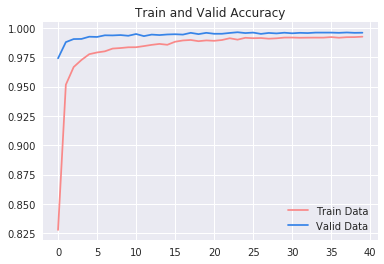

In [38]:
plt.title('Train and Valid Accuracy')
plt.plot(history.history['acc'], color='#F98989',label="Train Data")
plt.plot(history.history['val_acc'], color='#3784E8',label="Valid Data")
plt.legend()
plt.show()

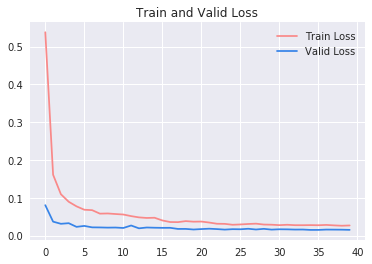

In [39]:
plt.title('Train and Valid Loss')
plt.plot(history.history['loss'], color='#F98989',label="Train Loss")
plt.plot(history.history['val_loss'], color='#3784E8',label="Valid Loss")
plt.legend()
plt.show()

In [40]:
# predict test data
predicted_classes = model.predict_classes(X_test)
test_acc =accuracy_score(y_test_0, predicted_classes)

 9984/10000 [============================>.] - ETA: 0s

In [41]:
if test_acc >= 0.995:
    print('Get Extra Credit !!') 
    print('MNIST Test Dataset Accuracy = {}%'.format(100*round(test_acc,3)))
else:
    print('Not reach above 99.5% accuracy !')
    print('Need to Adjust Your Parameters !')

Get Extra Credit !!
MNIST Test Dataset Accuracy = 99.7%


In [42]:
# load the saved model in local drive
# Skip the previous part

#best_model2 = load_model('bestmodel.h5') 

# verify test results
#y_score = best_model2.predict(X_test)
#y_pred =np.argmax(y_score, axis=1) #max value index =actual class
#test_acc_verify =accuracy_score(y_test_0, y_pred)

In [43]:
#print('Test Data - Accuracy Verify: {}%'.format(100*round(test_acc_verify,3)))

Test Data - Accuracy Verify: 99.7%
